In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers


from lib_classifNN import *
from lib_visu_classif import *

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import imutils

## In this file, we create a neural network with one hidden layer and apply it to the mnist dataset in order to address the classification problem.


Using TensorFlow backend.


In [3]:
# loading mnist and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# network parameters
batch_size = 128
num_classes = 10
epochs = 20

# dimensions for the NN:
# input dimension
Q = x_train.shape[1]
# hidden layer dimension
K = 100
# output dimension : classification
D = num_classes

# dropout rate
DROP_OUT = 0.5
N = x_train.shape[0]
# l2 regularization
#prior length scale
l = 1e-2
# precision parameter, un peu au pif pour l'instant
tau = 1e-1

lambd = DROP_OUT*l**2/(2*N)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(60000, 28, 28) (60000,) (10000, 28, 28)
60000 train samples
10000 test samples


## Create a sequential model with Keras 

In [13]:
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd),
               bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
# softmax layer
model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
model.add(Activation('softmax'))

In [14]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 79,500
Trainable params: 79,500
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training the network
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

In [7]:
# Evaluation of the network
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.111234539793
Test accuracy: 0.9733


## Obtaining model uncertainty

## Vizualise data points

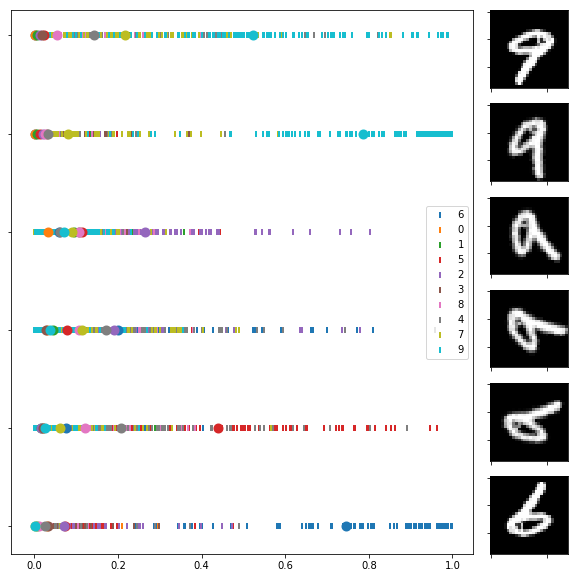

In [12]:
# change that parameter to see more classes on the plot
nb_show = 10
# index for the image sample
ix = 9
x_ex = x_test[ix]
#plot_pred_img(x_ex, model, nb_class=10)
#plt.show()
plot_rotated(x_ex, model , nb_class=10, nb_show= nb_show)
plt.show()

## Plot one example with its classification values

Network prediction: [[  8.81622886e-10   3.84498900e-12   3.33511374e-09   5.79132964e-09
    2.48310812e-08   9.85176206e-01   1.48189655e-02   3.66877405e-12
    4.39334417e-06   4.49413534e-07]]
Networ label: 5
dropout prediction: [ 0.01251055  0.00988531  0.02347066  0.01484859  0.04795705  0.56911766
  0.2309404   0.00845579  0.04789826  0.03491573]
dropout label: 5
real label: 5


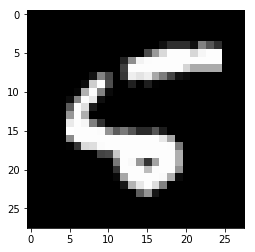

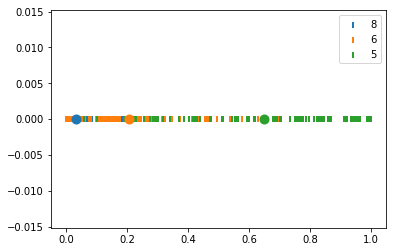

In [17]:
# change the drop_out rate to be more or less close to the classic network prediction
DROP_OUT = 0.5

ix = 8
x_ex = x_test[ix]
print("Network prediction: " + str(model.predict(x_ex.reshape((1, -1)))))
print("Networ label: "+ str(np.argmax(model.predict(x_ex.reshape((1, -1))))))

print("dropout prediction: "+ str(dropout_pred(x_ex, model, nb_cl=10, drop_out=DROP_OUT)))
print("dropout label: "+ str(dropout_pred(x_ex, model, nb_cl=10, label=True, drop_out = DROP_OUT)))

print("real label: " + str(np.argmax(y_test[ix])))

x_pl = x_ex.reshape((28,28))
plt.imshow(x_pl, cmap = "gray")
plt.show()

classes = np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
S_in, S_out = softmax_in_out(x_ex, model, nb_cl=10, drop_out= DROP_OUT)
plot_pred(S_out, classes, legend=True)
plt.show()